# Link sparsification Figure 1(a) and Figures 3

Latest update (Sep. 3, 2025): 
- update pandas DataFrame operations for python3.10
- adjust fonts in `matplotlib` and `seaborn` for IEEE TWC final version (Accepted fonts: Symbol, Helvetica, Arial, Time New Roman)

In [1]:
import os
import sys
import time
import scipy.io as sio
import scipy.sparse as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlp
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output

In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "ps.fonttype": 42,      # embed TrueType in EPS
    "pdf.fonttype": 42,
    "savefig.transparent": False,  # no page transparency (EPS can't do alpha)
    "legend.framealpha": 1.0,      # if you use legends, make them opaque
})

## Fig. 1(a): distribution of link utility 

In [4]:
wt_sel = 'qr'
output_dir = './wireless'
wts_sample_file = os.path.join(output_dir, 'samples_{}.txt'.format(wt_sel))
print(wts_sample_file)

./wireless/samples_qr.txt


In [12]:
with open(wts_sample_file, 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('[]', 'value\n')
filedata = filedata.replace('[', '').replace(']',',').replace(', ','\n').replace(',','\n')

# Write the file out again
with open(wts_sample_file, 'w') as file:
    file.write(filedata)

In [5]:
samp_df = pd.read_csv(wts_sample_file, index_col=False)
samp_df

,value
0,122.0
1,63.0
2,0.0
3,0.0
4,42.0
...,...
1872585,574.0
1872586,235.0
1872587,162.0
1872588,396.0


In [6]:
samp_df.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,value
count,1.872590e+06
mean,7.577485e+02
std,1.486059e+03
min,0.000000e+00
25%,1.250000e+02
50%,3.160000e+02
75%,7.380000e+02
95%,2.926000e+03
99%,8.195000e+03
max,2.960000e+04


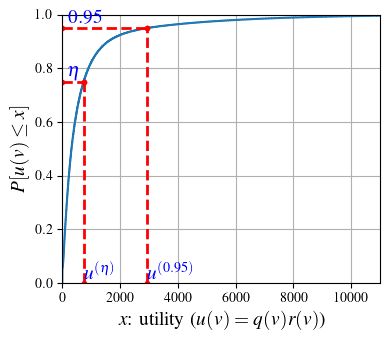

In [7]:
fontsize=14
# df.hist(cumulative=True, density=1, bins=100)
fig = plt.figure(figsize=(4,3.5))
ax = sns.ecdfplot(data=samp_df, x='value')
ax.grid(True)
ax.set_xlabel('$x$: utility ($u(v)=q(v)r(v)$)', fontsize=fontsize)
ax.set_ylabel('$P[u(v)\leq x]$', fontsize=fontsize)
ax.set_xlim([0, 11000])
plt.plot([0, 2926], [0.95,0.95], color='red', marker='.', linestyle='dashed', linewidth=2)
plt.plot([2926, 2926], [0.,0.95], color='red', marker='.', linestyle='dashed', linewidth=2)
plt.plot([0, 738], [0.75,0.75], color='red', marker='.', linestyle='dashed', linewidth=2)
plt.plot([738, 738], [0.,0.75], color='red', marker='.', linestyle='dashed', linewidth=2)
plt.annotate('$0.95$', (0, 0.95), fontsize=fontsize, va='bottom', ha='left', color='blue', xytext=(200,0.95))
plt.annotate('$u^{(0.95)}$', (2926, 0), fontsize=fontsize, va='bottom', ha='left', color='blue')
plt.annotate('$\eta$', (0, 0.75), fontsize=fontsize, va='bottom', ha='left', color='blue', xytext=(200,0.75))
plt.annotate('$u^{(\eta)}$', (738, 0), fontsize=fontsize, va='bottom', ha='left', color='blue')

# fig = plt.gcf()
# fig.set_size_inches(4.5,4)
fname='./output/eCDF_utility_qr_load-003_007_greedy.pdf'
plt.tight_layout()
fig.savefig(fname,
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            bbox_inches='tight',
            pad_inches=0.02,
            format='pdf')
fname='./output/eCDF_utility_qr_load-003_007_greedy.eps'
fig.savefig(fname,
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            bbox_inches='tight',
            pad_inches=0.02,
            format='eps')
# ax.set_yticks(np.arange(0.0, 1.1, 0.1))

# Figures 3: comparison of thresholding policies on total utility 

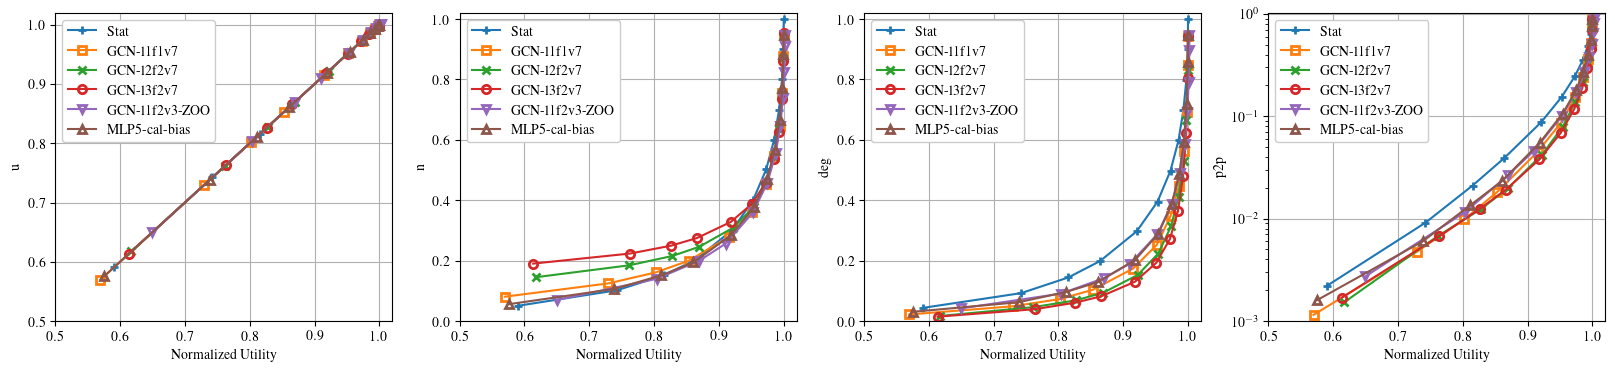

In [9]:
csvfiles = {'Stat': './wireless/benchmark_sparsify_quantiles_test.csv',
            'icassp': './wireless/test_sparsify_quantiles_test_SPASingle_ER_Graph_Uniform_GEN21_test2.csv',
            'icassp-cal-wts': './wireless/test_sparsify_quantiles_norm_SPASingle_ER_Graph_Uniform_GEN21_test2_wz0.csv',
            'icassp-cal-bias': './wireless/test_sparsify_quantiles_norm_SPASingle_ER_Graph_Uniform_GEN21_test2_bz0.csv',
            'L1F2v3-cal-wts': './wireless/test_sparsify_quantiles_norm_SPAl1f2v3_ER_Graph_Uniform_GEN21_test2_wz0.csv',
            'L1F2v3-cal-bias': './wireless/test_sparsify_quantiles_norm_SPAl1f2v3_ER_Graph_Uniform_GEN21_test2_bz0.csv',
            'L3F2v3-cal-wts': './wireless/test_sparsify_quantiles_norm_SPAOrigin_ER_Graph_Uniform_GEN21_test2_wz0.csv',
            'L3F2v3-cal-bias': './wireless/test_sparsify_quantiles_norm_SPAOrigin_ER_Graph_Uniform_GEN21_test2_bz0.csv',
            'MLP5': './wireless/test_sparsify_quantiles_test_SPAMLP5_ER_Graph_Uniform_GEN21_test2.csv',
            'MLP5-cal-wts': './wireless/test_sparsify_quantiles_norm_SPAMLP5_ER_Graph_Uniform_GEN21_test2_wz0.csv',
            'MLP5-cal-bias': './wireless/test_sparsify_quantiles_norm_SPAMLP5_ER_Graph_Uniform_GEN21_test2_bz0.csv',
            'GCN-l1f2v3': './wireless/test_sparsify_quantiles_test_SPAl1f2v3_ER_Graph_Uniform_GEN21_test2.csv',
            'GCN-l1f2v3-ZOO': './wireless/test_sparsify_quantiles_zoo_test_SPAZOOS.csv',
            'GCN-l1f1v7': './wireless/test_sparsify_quantiles_test_result_SPAFooF1v8_deep_ld1_c32_l1_cheb1_diver1_mwis_actor_ER_Graph_Uniform_GEN21_test2.csv',
            'GCN-l1f2v7': './wireless/test_sparsify_quantiles_test_result_SPAFooF1v7_deep_ld2_c32_l1_cheb1_diver1_mwis_actor_ER_Graph_Uniform_GEN21_test2.csv',
            'GCN-l2f1v7': './wireless/test_sparsify_quantiles_test_result_SPAFooF1v8_deep_ld1_c32_l2_cheb1_diver1_mwis_actor_ER_Graph_Uniform_GEN21_test2.csv',
            'GCN-l3f1v7': './wireless/test_sparsify_quantiles_test_result_SPAFooF1v8_deep_ld1_c32_l3_cheb1_diver1_mwis_actor_ER_Graph_Uniform_GEN21_test2.csv',
            'GCN-l3f2v7': './wireless/test_sparsify_quantiles_test_result_SPAFooF1v7_deep_ld2_c32_l3_cheb1_diver1_mwis_actor_ER_Graph_Uniform_GEN21_test2.csv',
            'GCN-l2f2v7': './wireless/test_sparsify_quantiles_test_result_SPAFooF1v7_deep_ld2_c32_l2_cheb1_diver1_mwis_actor_ER_Graph_Uniform_GEN21_test2.csv',
           }

df_dict = {}
mk_dict = {}
markers = ['+','s','x','o','v','^','d','p','*','h','.',',']
# plot_list = ['Stat','icassp', 'icassp-cal-wts', 'icassp-cal-bias','MLP5-cal-wts','MLP5-cal-wts']
# plot_list = ['Stat','icassp', 'L1F2v3-cal-wts', 'L1F2v3-cal-bias','MLP5-cal-wts','MLP5-cal-bias']
# plot_list = ['Stat','icassp', 'icassp-cal-bias', 'L3F2v3-cal-bias','MLP5-cal-bias']
# plot_list = ['Stat','icassp', 'icassp-cal-wts', 'L3F2v3-cal-wts','MLP5-cal-wts']
plot_list = ['Stat',
             # 'icassp', 
             'GCN-l1f1v7', 
             'GCN-l2f2v7', 
             'GCN-l3f2v7', 
             # 'icassp-cal-bias', 
             'GCN-l1f2v3-ZOO',
             'MLP5-cal-bias']

midx = 0
for key in plot_list:
    tmp_df = pd.read_csv(csvfiles[key], index_col=False)
    tmp_df['ilevel'] = 1-tmp_df['level']
    tmp_df['deg'] = tmp_df['ds']/tmp_df['df']
    tmp_df['u_'] = tmp_df['u']-1e-4
    df_dict[key] = tmp_df.copy(deep=True)
    mk_dict[key] = markers[midx % len(markers)]
    midx += 1


fig, axs = plt.subplots(1,4,sharey=False, figsize=(20, 4))
# fig2, axs2 = plt.subplots(1,4,sharey=False, figsize=(20, 4))
i=0

cmap = plt.get_cmap("tab10")

lines = {}
# for item in ['u', 'n', 'deg', 'e', 'p2p']:
for item in ['u', 'n', 'deg', 'p2p']:
# for item in ['ilevel', 'n', 'deg', 'p2p']:
    legend_text = []
    cidx = 0
    for key in plot_list:
        color = cmap(cidx)
#         line = sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
#         sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
        df_tmp = df_dict[key].groupby('level').mean(numeric_only=True)
        sns.lineplot(data=df_tmp, x='u', y=item, marker=mk_dict[key], ax=axs[i],
                     errorbar=None,
                     color=color, mec=color, mfc="None", mew=2)
        legend_text.append(key)
        cidx += 1
#         lines[key] = line

    axs[i].set_xlim([0.5,1.02])
#     axs[i].set_xlim([0,1.02])
    axs[i].set_ylim([0,1.02])
    if item in ['u']:
        axs[i].set_ylim([0.5,1.02])
    if item in ['e', 'p2p']:
        axs[i].set_ylim([0.001,1.02])
        axs[i].set_yscale('log')
    axs[i].grid(True)
    axs[i].legend(legend_text)
#     axs[i].set_xlabel('Cut-off quantile')
    axs[i].set_xlabel('Normalized Utility')
    

    i += 1

/tmp/ipykernel_88141/3135160957.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])
/tmp/ipykernel_88141/3135160957.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])
/tmp/ipykernel_88141/3135160957.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])


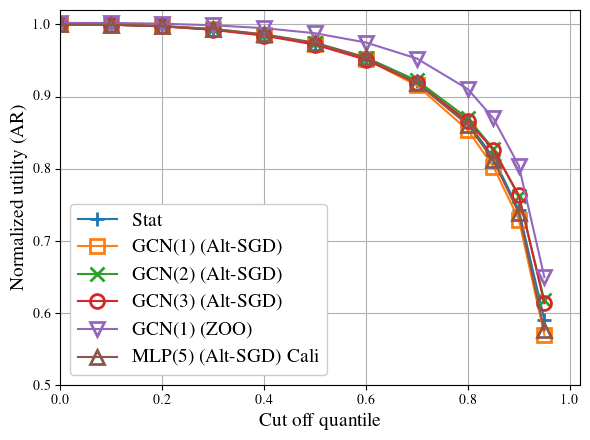

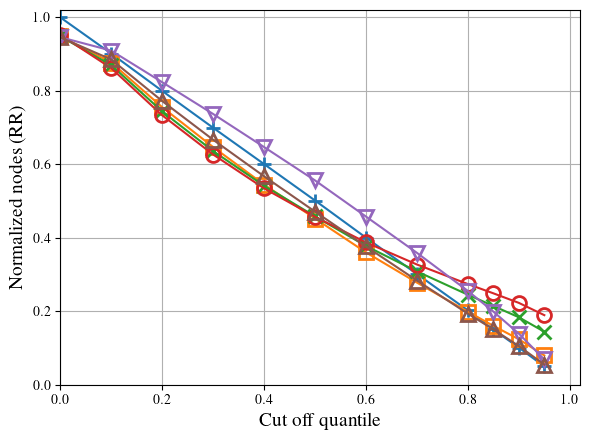

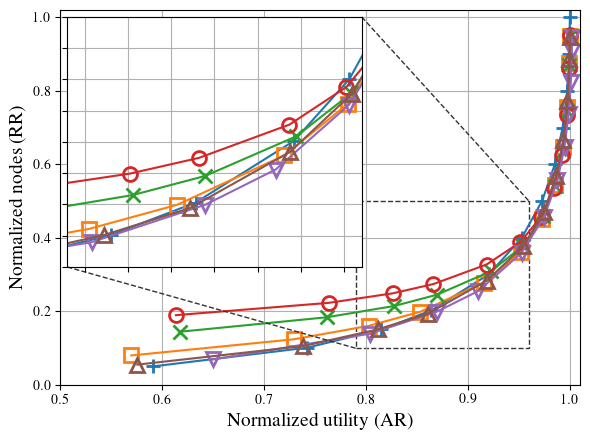

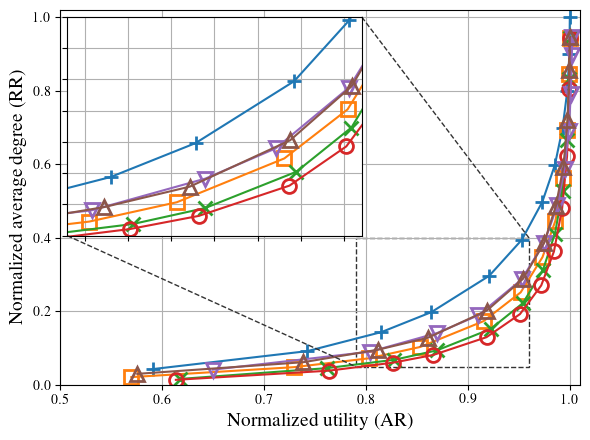

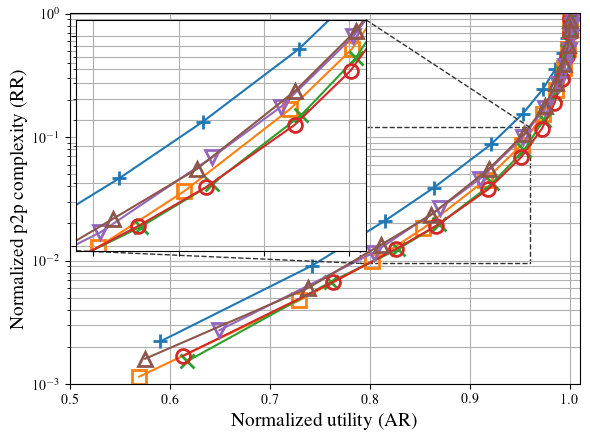

In [10]:
# for item in ['u', 'n', 'deg', 'e', 'p2p']:
i = 0
fontsize = 14
legend_text_dict = {'Stat': 'Stat',
                    'icassp': 'GCN(1) (2-stage)', 
                    'icassp-cal-bias': 'GCN(1) (2-stage) Cali', 
                    'L3F2v3-cal-bias': 'GCN(1) (Alt-SGD)',
                    'MLP5-cal-bias': 'MLP(5) (Alt-SGD) Cali',
                    'GCN-l1f2v3': 'GCN(1) (Alt-SGD)',
                    'GCN-l1f2v3-ZOO': 'GCN(1) (ZOO)',
                    'GCN-l1f1v2': 'GCN(1) (Alt-SGD)',
                    'GCN-l1f2v7': 'GCN(1) (Alt-SGD)',
                    'GCN-l1f1v7': 'GCN(1) (Alt-SGD)',
                    'GCN-l2f1v7': 'GCN(2) (Alt-SGD)',
                    'GCN-l2f2v7': 'GCN(2) (Alt-SGD)',
                    'GCN-l3f1v7': 'GCN(3) (Alt-SGD)',
                    'GCN-l3f2v7': 'GCN(3) (Alt-SGD)',
                   }
y_label_dict={
    'u': "utility (AR)",
    'n': "nodes (RR)",
    'deg': "average degree (RR)",
    'p2p': "p2p complexity (RR)",
}

for item in ['u', 'n']:
    fig, ax = plt.subplots(1,1,sharey=False, figsize=(8, 6))
# for item in ['ilevel', 'n', 'deg', 'p2p']:
    legend_text = []
    cidx = 0
    for key in plot_list:
        color = cmap(cidx)
#         line = sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
#         sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
        df_tmp = df_dict[key].groupby('level').mean(numeric_only=True)
        sns.lineplot(data=df_tmp, x='level', y=item, marker=mk_dict[key], ax=ax, 
                     color=color, mec=color, mfc="None", mew=2, markersize=10,
                     errorbar=None,
                    )
        legend_text.append(legend_text_dict[key])
        cidx += 1
#         lines[key] = line

    ax.set_xlim([0.0,1.02])
#     axs[i].set_xlim([0,1.02])
    ax.set_ylim([0,1.02])
    ax.grid(True)
    if item in ['u']:
        ax.set_ylim([0.5,1.02])
        ax.legend(legend_text, fontsize=fontsize)
    if item in ['e', 'p2p']:
        ax.set_ylim([0.0005,1.02])
        ax.set_yscale('log')
        ax.grid('minor')
#     axs[i].set_xlabel('Cut-off quantile')
    ax.set_xlabel('Cut off quantile', fontsize=fontsize)
    ax.set_ylabel("Normalized {}".format(y_label_dict[item]), fontsize=fontsize)
    fig.set_size_inches(6, 4.5)
    fname='./output/sparsify_exp1_{}_vs_level_er.pdf'.format(item)
    pp = PdfPages(fname)
    plt.tight_layout()
    fig.savefig(fname, 
                dpi=300, #facecolor='w', edgecolor='w',
                orientation='portrait',
                pad_inches=0.01,
                bbox_inches='tight',
                format='pdf')
    fig.savefig(fname.replace('.pdf','.eps'), 
                dpi=300, #facecolor='w', edgecolor='w',
                orientation='portrait',
                pad_inches=0.01,
                bbox_inches='tight',
                format='eps')
    
for item in ['n', 'deg', 'p2p']:
    fig, ax = plt.subplots(1,1,sharey=False, figsize=(8, 6))
# for item in ['ilevel', 'n', 'deg', 'p2p']:
    legend_text = []
    cidx = 0
    axins = zoomed_inset_axes(ax, 1.7, loc=2)
    for key in plot_list:
        color = cmap(cidx)
#         line = sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
#         sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
        df_tmp = df_dict[key].groupby('level').mean(numeric_only=True)
        sns.lineplot(data=df_tmp, x='u', y=item, marker=mk_dict[key], ax=ax, 
                     color=color, mec=color, mfc="None", mew=2, markersize=10,
                     errorbar=None,
                    )
        sns.lineplot(data=df_tmp, x='u', y=item, marker=mk_dict[key], ax=axins, 
                     color=color, mec=color, mfc="None", mew=2, markersize=10,
                     errorbar=None,
                    )
        legend_text.append(legend_text_dict[key])
        cidx += 1
#         lines[key] = line

    axins.xaxis.set_tick_params(labelbottom=False)
    axins.yaxis.set_tick_params(labelleft=False)

    ax.set_xlim([0.5,1.01])
#     axs[i].set_xlim([0,1.02])
    ax.set_ylim([0,1.02])
    ax.grid(True)
    if item in ['n']:
        ax.set_ylim([0,1.02])
        x1, x2, y1, y2 = 0.79, 0.96, 0.1, 0.5
        axins.grid('minor')
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
    if item in ['deg']:
        x1, x2, y1, y2 = 0.79, 0.96, 0.05, 0.4
        axins.grid('minor')
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
    if item in ['e', 'p2p']:
        ax.set_ylim([0.001,1.02])
        ax.set_yscale('log')
        ax.grid(True, 'both')
        axins.set_yscale('log')
        axins.grid(True, 'both')
        x1, x2, y1, y2 = 0.79, 0.96, 0.0095, 0.12
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
    axins.set_xlabel('')
    axins.set_ylabel('')
#     ax.legend(legend_text, fontsize=fontsize)
#     axs[i].set_xlabel('Cut-off quantile')
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.2", ls='--')

    ax.set_xlabel('Normalized utility (AR)', fontsize=fontsize)
    ax.set_ylabel("Normalized {}".format(y_label_dict[item]), fontsize=fontsize)
    ax.margins(-0.05)
    fig.set_size_inches(6, 4.5)
    fname='./output/sparsify_exp1_{}_vs_u_er.pdf'.format(item)
    pp = PdfPages(fname)
    plt.tight_layout(rect=[0,0,1,1])
    fig.savefig(fname, 
                dpi=300, #facecolor='w', edgecolor='w',
                orientation='portrait',
                pad_inches=0.01,
                bbox_inches='tight',
                format='pdf')
    fig.savefig(fname.replace('.pdf','.eps'), 
                dpi=300, #facecolor='w', edgecolor='w',
                orientation='portrait',
                pad_inches=0.01,
                bbox_inches='tight',
                format='eps')
    i += 1

/tmp/ipykernel_88141/2925290271.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])
/tmp/ipykernel_88141/2925290271.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])
/tmp/ipykernel_88141/2925290271.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])


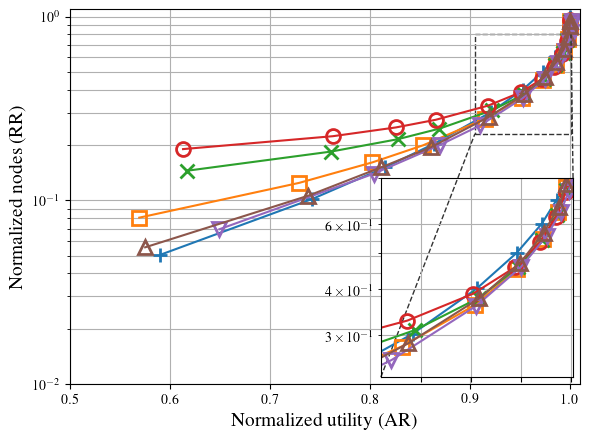

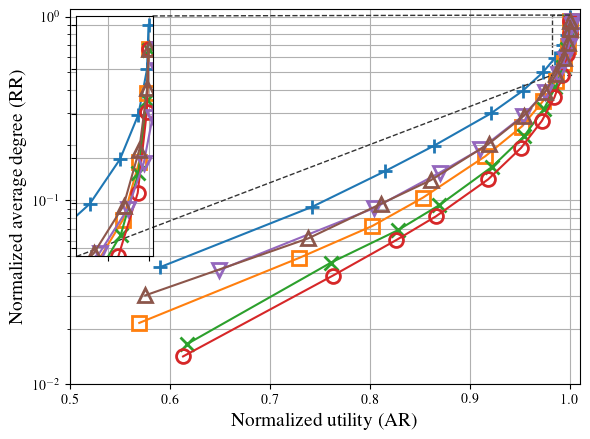

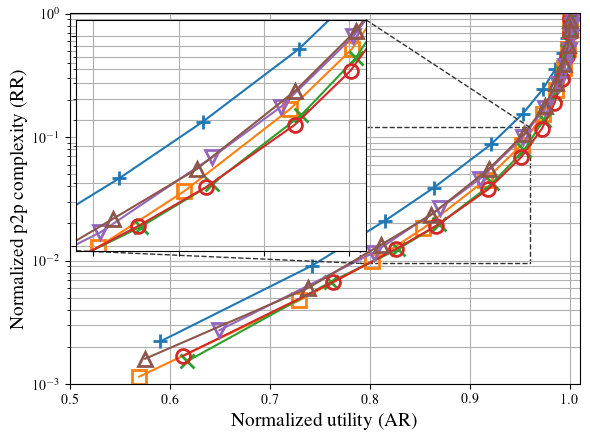

In [11]:
# for item in ['u', 'n', 'deg', 'e', 'p2p']:
i = 0
fontsize = 14
legend_text_dict = {'Stat': 'Stat',
                    'icassp': 'GCN(1) (2-stage)', 
                    'icassp-cal-bias': 'GCN(1) (2-stage) Cali', 
                    'L3F2v3-cal-bias': 'GCN(1) (Alt-SGD)',
                    'MLP5-cal-bias': 'MLP(5) (Alt-SGD) Cali',
                    'GCN-l1f2v3': 'GCN(1) (Alt-SGD)',
                    'GCN-l1f2v3-ZOO': 'GCN(1) (ZOO)',
                    'GCN-l1f1v2': 'GCN(1) (Alt-SGD)',
                    'GCN-l1f2v7': 'GCN(1) (Alt-SGD)',
                    'GCN-l1f1v7': 'GCN(1) (Alt-SGD)',
                    'GCN-l2f1v7': 'GCN(2) (Alt-SGD)',
                    'GCN-l2f2v7': 'GCN(2) (Alt-SGD)',
                    'GCN-l3f1v7': 'GCN(3) (Alt-SGD)',
                    'GCN-l3f2v7': 'GCN(3) (Alt-SGD)',
                   }
y_label_dict={
    'u': "utility (AR)",
    'n': "nodes (RR)",
    'deg': "average degree (RR)",
    'p2p': "p2p complexity (RR)",
}

    
for item in ['n', 'deg', 'p2p']:
    fig, ax = plt.subplots(1,1,sharey=False, figsize=(8, 6))
# for item in ['ilevel', 'n', 'deg', 'p2p']:
    legend_text = []
    cidx = 0
    if item in ['p2p']:
        axins = zoomed_inset_axes(ax, 1.7, loc=2)
    elif item in ['deg']:
        axins = zoomed_inset_axes(ax, 4, loc=2, axes_kwargs={'autoscale_on':'on'})
    elif item in ['n']:
        axins = zoomed_inset_axes(ax, 2., loc=4)
    for key in plot_list:
        color = cmap(cidx)
#         line = sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
#         sns.lineplot(data=df_dict[key], x='level', y=item, marker=mk_dict[key], ax=axs[i], color=color, mec=color, mfc="None", mew=2)
        df_tmp = df_dict[key].groupby('level').mean(numeric_only=True)
        sns.lineplot(data=df_tmp, x='u', y=item, marker=mk_dict[key], ax=ax, 
                     color=color, mec=color, mfc="None", mew=2, markersize=10,
                     errorbar=None,
                    )
        sns.lineplot(data=df_tmp, x='u', y=item, marker=mk_dict[key], ax=axins, 
                     color=color, mec=color, mfc="None", mew=2, markersize=10,
                     errorbar=None,
                    )
        legend_text.append(legend_text_dict[key])
        cidx += 1
#         lines[key] = line

    axins.xaxis.set_tick_params(labelbottom=False)
    axins.yaxis.set_tick_params(labelleft=False)

    ax.set_xlim([0.5,1.01])
#     axs[i].set_xlim([0,1.02])
    ax.set_ylim([0,1.02])
    ax.grid(True)
#     ax.set_xscale('log1minus')
    if item in ['n']:
        ax.set_ylim([0.01,1.1])
        ax.set_yscale('log')
        ax.grid(True, 'both')
#         x1, x2, y1, y2 = 0.795, 0.96, 0.13, 0.45
        x1, x2, y1, y2 = 0.905, 1.001, 0.23, 0.8
        axins.set_yscale('log')
        axins.grid(True, 'both')
#         axins.grid('minor')
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
    if item in ['deg']:
        ax.set_ylim([0.01,1.1])
        ax.set_yscale('log')
        ax.grid(True, 'both')
#         axins = zoomed_inset_axes(ax, 2.5, loc=2)
#         axins.set_yscale('log')
        axins.grid(True, 'both')
        x1, x2, y1, y2 = 0.982, 1.001, 0.48, 1.02
#         x1, x2, y1, y2 = 0.79, 0.96, 0.05, 0.4
#         axins.grid('minor')
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
    if item in ['e', 'p2p']:
        ax.set_ylim([0.001,1.02])
        ax.set_yscale('log')
        ax.grid(True, 'both')
        axins.set_yscale('log')
        axins.grid(True, 'both')
        x1, x2, y1, y2 = 0.79, 0.96, 0.0095, 0.12
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
    axins.set_xlabel('')
    axins.set_ylabel('')
#     ax.legend(legend_text, fontsize=fontsize)
#     axs[i].set_xlabel('Cut-off quantile')
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.2", ls='--')

    ax.set_xlabel('Normalized utility (AR)', fontsize=fontsize)
    ax.set_ylabel("Normalized {}".format(y_label_dict[item]), fontsize=fontsize)
    ax.margins(-0.05)
    fig.set_size_inches(6, 4.5)
    fname='./output/sparsify_exp1_{}_vs_u_er_logy.pdf'.format(item)
    pp = PdfPages(fname)
    plt.tight_layout(rect=[0,0,1,1])
    fig.savefig(fname, 
                dpi=300, #facecolor='w', edgecolor='w',
                orientation='portrait',
                pad_inches=0.01,
                bbox_inches='tight',
                format='pdf')
    fig.savefig(fname.replace('.pdf','.eps'), 
                dpi=300, #facecolor='w', edgecolor='w',
                orientation='portrait',
                pad_inches=0.01,
                bbox_inches='tight',
                format='eps')
    i += 1

In [51]:
df_dict['GCN-l3f2v7'].groupby('level').mean()

,u,n,e,s,avg_val,bst,df,ds,p2p,ilevel,deg,u_
level,,,,,,,,,,,,
0.00,1.000000,0.952588,0.900373,0.987333,NaN,0.955557,5.163429,4.883296,0.899563,1.00,0.944866,0.999900
0.10,0.999576,0.861842,0.694537,0.967433,NaN,0.876838,5.163429,4.253192,0.694833,0.90,0.805220,0.999476
0.20,0.997298,0.733609,0.456305,0.921767,NaN,0.758955,5.163429,3.374517,0.455332,0.80,0.622590,0.997198
0.30,0.992466,0.626951,0.299564,0.872000,NaN,0.657497,5.163429,2.652746,0.297645,0.70,0.480494,0.992366
0.40,0.984442,0.534898,0.191580,0.814033,NaN,0.566817,5.163429,2.036299,0.188633,0.60,0.363346,0.984342
0.50,0.971963,0.457577,0.120414,0.750033,NaN,0.490576,5.163429,1.541001,0.117301,0.50,0.270878,0.971863
0.60,0.951097,0.387843,0.071284,0.664200,NaN,0.420494,5.163429,1.108983,0.068593,0.40,0.192879,0.950997
0.70,0.918266,0.327763,0.039868,0.585433,NaN,0.360178,5.163429,0.751063,0.037821,0.30,0.130097,0.918166
0.80,0.865989,0.274473,0.020357,0.515667,NaN,0.307141,5.163429,0.472002,0.019060,0.20,0.081733,0.865889


In [77]:
df = df_dict['Stat']
df.groupby('level').mean()

,u,n,e,s,bst,df,ds,p2p,ilevel,deg
level,,,,,,,,,,
0.00,1.000000,1.000000,1.000000,1.000000,1.000000,10.326859,10.326859,1.000000,1.00,1.000000
0.10,0.999630,0.901551,0.812621,0.968133,0.902652,10.326859,9.314446,0.809978,0.90,0.900737
0.20,0.997464,0.799895,0.639712,0.942933,0.804428,10.326859,8.251059,0.635742,0.80,0.798538
0.30,0.992879,0.699672,0.489911,0.910500,0.705703,10.326859,7.209854,0.484723,0.70,0.698427
0.40,0.985341,0.600898,0.361068,0.867300,0.608263,10.326859,6.186360,0.355165,0.60,0.598393
0.50,0.972990,0.501826,0.251320,0.817433,0.510645,10.326859,5.151258,0.245791,0.50,0.497892
0.60,0.952916,0.400753,0.159710,0.767500,0.410671,10.326859,4.093527,0.155129,0.40,0.395013
0.70,0.920944,0.301822,0.090837,0.699033,0.312819,10.326859,3.075155,0.087315,0.30,0.297123
0.80,0.864079,0.203014,0.041100,0.603600,0.213907,10.326859,2.066527,0.039059,0.20,0.198149


In [24]:
i=0
ylabels = {'u': 'Approx. Ratio (utility)',
           'n': 'Retention Ratio (nodes)',
           'e': 'Retention Ratio ($|\mathcal{E}^s|$)',
           'deg': 'Retention Ratio ($\overline{d}$)',
           'p2p': 'Retention Ratio (P2P)'
          }
fnames = {'u': 'sparse_graph_utility.pdf',
           'n': 'sparse_graph_nodes.pdf',
           'e': 'sparse_graph_edges.pdf',
           'deg': 'sparse_graph_avg_deg.pdf',
           'p2p': 'sparse_graph_p2p.pdf'
          }
for item in ['u', 'n', 'e', 'deg', 'p2p']:
#     fig, ax = plt.subplots(figsize=(4, 3))
    ax = sns.lineplot(data=nn_df, x='level', y=item, marker='o', mec='k') # mfc="None", mew=2
#     sns.lineplot(data=test_df, x='level', y=item, marker='o', mec='k', ax=ax)
    sns.lineplot(data=bm_df, x='level', y=item, marker='X', mec='k', ax=ax)
    ax.set_xlim([-0.02,1.02])
    if item == 'u':
        ax.set_ylim([0.48, 1.02])
    else:
        ax.set_ylim([-0.02,1.02])
    ax.grid(True)
    if item == 'p2p':
        ax.set_yscale('log')
        ax.set_ylim([0.001,1.2])
        ax.grid(True, which='both')
    ax.legend(['GCN','Stat'], fontsize=12)
    ax.set_xlabel('cut-off quantile $\eta$', fontsize=12)
    ax.set_ylabel(ylabels[item], fontsize=12)
    i += 1
    fig = plt.gcf()
    fig.set_size_inches(4, 3)
    fname= os.path.join('./output/', fnames[item])
    plt.tight_layout()
    fig.savefig(fname,
                dpi=300, #facecolor='w', edgecolor='w',
                bbox_inches='tight',
                pad_inches=0.02,
                orientation='portrait',
                format='pdf')
    plt.close(fig)

In [140]:
bm_df

,level,u,n,e,s,graph,bst,df,ds,p2p,ilevel
0,0.00,1.000000,1.000000,1.000000,1.000000,ER_n100_p0.02_b0_uni.mat,1.000000,1.960000,1.960000,1.000000,1.00
1,0.10,0.999539,0.870000,0.775510,1.000000,ER_n100_p0.02_b0_uni.mat,0.851648,1.960000,1.747126,0.770642,0.90
2,0.20,0.991177,0.760000,0.622449,0.666667,ER_n100_p0.02_b0_uni.mat,0.703297,1.960000,1.605263,0.596330,0.80
3,0.30,0.986603,0.650000,0.397959,0.666667,ER_n100_p0.02_b0_uni.mat,0.609890,1.960000,1.200000,0.366972,0.70
4,0.40,0.983378,0.590000,0.316327,0.666667,ER_n100_p0.02_b0_uni.mat,0.560440,1.960000,1.050847,0.284404,0.60
...,...,...,...,...,...,...,...,...,...,...,...
5995,0.70,0.956699,0.293333,0.081330,0.750000,ER_n300_p0.067_b9_uni.mat,0.311609,20.246667,5.613636,0.077537,0.30
5996,0.80,0.896370,0.200000,0.039842,0.500000,ER_n300_p0.067_b9_uni.mat,0.211813,20.246667,4.033333,0.038198,0.20
5997,0.90,0.766386,0.076667,0.005268,0.500000,ER_n300_p0.067_b9_uni.mat,0.085540,20.246667,1.391304,0.004561,0.10
5998,0.85,0.860381,0.130000,0.017451,0.500000,ER_n300_p0.067_b9_uni.mat,0.144603,20.246667,2.717949,0.016534,0.15


In [30]:
nn_df['deg'].loc[nn_df['level']==0.95].mean()

0.02643994684133402

In [3]:
level = 0.95
graph = 'ertest'
csvfile = './wireless/metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-{}_load-0.03_layer-1_level-{}_sparsify_nonorm.csv'.format(graph, level)
ws_df = pd.read_csv(csvfile, index_col=False)
ws_df

,graph,seed,load,name,avg_queue_len,50p_queue_len,95p_queue_len,avg_throughput,avg_n_ratio,avg_e_ratio,avg_deg_sp,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree
0,ER_n100_p0.02_b0_uni.mat,3346058,0.042,Greedy,1.292933,0.006667,5.0,2.076000,0.996667,0.996667,0.980000,1.000000,1.000000,1.000000,1.000000,1.960000
1,ER_n100_p0.02_b0_uni.mat,3346058,0.042,single,20.638200,20.103333,44.0,2.009033,0.048633,0.002619,0.082952,0.405330,0.002526,0.056588,0.207091,1.960000
2,ER_n100_p0.02_b0_uni.mat,3346058,0.042,DGCN-LGS,20.849900,9.468333,81.0,2.006100,0.397467,0.007483,0.017937,0.420757,0.007217,0.469511,0.204779,1.960000
3,ER_n100_p0.02_b10_uni.mat,3367678,0.035,Greedy,0.982167,0.000000,4.0,1.732733,0.996667,0.996667,0.920000,1.000000,1.000000,1.000000,1.000000,1.840000
4,ER_n100_p0.02_b10_uni.mat,3367678,0.035,single,20.009567,19.610000,42.0,1.669933,0.041500,0.002174,0.070767,0.400000,0.002094,0.047333,0.177402,1.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,ER_n300_p0.067_b8_uni.mat,9129847,0.039,single,22.122533,21.540000,46.0,1.861467,0.063756,0.004280,1.222483,0.410543,0.004012,0.070442,0.461781,19.593333
1496,ER_n300_p0.067_b8_uni.mat,9129847,0.039,DGCN-LGS,26.416867,23.590000,64.0,1.847378,0.073800,0.003316,0.408028,0.394569,0.003064,0.082870,0.416952,19.593333
1497,ER_n300_p0.067_b9_uni.mat,9227914,0.031,Greedy,5.500878,4.741667,14.0,1.528611,0.996667,0.996667,10.123333,1.000000,1.000000,1.000000,1.000000,20.246667
1498,ER_n300_p0.067_b9_uni.mat,9227914,0.031,single,20.826367,20.418333,44.0,1.477289,0.049289,0.002506,0.940991,0.361685,0.002314,0.055558,0.409427,20.246667


In [4]:
def extract_Np(filename):
    list_para = filename[0:-4].split('_')
    N_p=round(float(list_para[2][1:])*float(list_para[1][1:]),0)
    return N_p

def extract_N(filename):
    list_para = filename[0:-4].split('_')
    N=int(list_para[1][1:])
    return N
    
def extract_df_info(df):
    df['N_p'] = df['graph'].apply(extract_Np)
    df['N'] = df['graph'].apply(extract_N)
    return df

In [5]:
ws_df = extract_df_info(ws_df)
ws_df['avg_degree'] = ws_df['avg_degree']/2
ws_df['avg_d_ratio'] = ws_df['avg_deg_sp'] / ws_df['avg_degree']
ws_df

,graph,seed,load,name,avg_queue_len,50p_queue_len,95p_queue_len,avg_throughput,avg_n_ratio,avg_e_ratio,avg_deg_sp,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree,N_p,N,avg_d_ratio
0,ER_n100_p0.02_b0_uni.mat,3346058,0.042,Greedy,1.292933,0.006667,5.0,2.076000,0.996667,0.996667,0.980000,1.000000,1.000000,1.000000,1.000000,0.980000,2.0,100,1.000000
1,ER_n100_p0.02_b0_uni.mat,3346058,0.042,single,20.638200,20.103333,44.0,2.009033,0.048633,0.002619,0.082952,0.405330,0.002526,0.056588,0.207091,0.980000,2.0,100,0.084645
2,ER_n100_p0.02_b0_uni.mat,3346058,0.042,DGCN-LGS,20.849900,9.468333,81.0,2.006100,0.397467,0.007483,0.017937,0.420757,0.007217,0.469511,0.204779,0.980000,2.0,100,0.018303
3,ER_n100_p0.02_b10_uni.mat,3367678,0.035,Greedy,0.982167,0.000000,4.0,1.732733,0.996667,0.996667,0.920000,1.000000,1.000000,1.000000,1.000000,0.920000,2.0,100,1.000000
4,ER_n100_p0.02_b10_uni.mat,3367678,0.035,single,20.009567,19.610000,42.0,1.669933,0.041500,0.002174,0.070767,0.400000,0.002094,0.047333,0.177402,0.920000,2.0,100,0.076921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,ER_n300_p0.067_b8_uni.mat,9129847,0.039,single,22.122533,21.540000,46.0,1.861467,0.063756,0.004280,1.222483,0.410543,0.004012,0.070442,0.461781,9.796667,20.0,300,0.124786
1496,ER_n300_p0.067_b8_uni.mat,9129847,0.039,DGCN-LGS,26.416867,23.590000,64.0,1.847378,0.073800,0.003316,0.408028,0.394569,0.003064,0.082870,0.416952,9.796667,20.0,300,0.041650
1497,ER_n300_p0.067_b9_uni.mat,9227914,0.031,Greedy,5.500878,4.741667,14.0,1.528611,0.996667,0.996667,10.123333,1.000000,1.000000,1.000000,1.000000,10.123333,20.0,300,1.000000
1498,ER_n300_p0.067_b9_uni.mat,9227914,0.031,single,20.826367,20.418333,44.0,1.477289,0.049289,0.002506,0.940991,0.361685,0.002314,0.055558,0.409427,10.123333,20.0,300,0.092953


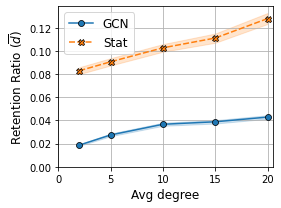

In [25]:
df = ws_df.loc[ws_df['name'].isin(['single','DGCN-LGS'])]

ax = sns.lineplot(data=df, x='N_p', y='avg_d_ratio',  
                  hue='name', hue_order=['DGCN-LGS', 'single'], 
                  style='name', style_order=['DGCN-LGS', 'single'], 
                  markers=True, mec='k')
# sns.lineplot(data=bm_df, x='level', y=item, marker='o', ax=ax)
ax.set_xlim([0.0, 20.5])
ax.set_ylim([0.0, None])
ax.grid(True)
ax.legend(['GCN','Stat'], fontsize=12)
ax.set_xlabel('Avg degree', fontsize=12)
ax.set_ylabel('Retention Ratio ($\overline{d}$)', fontsize=12)
# i += 1
fig = plt.gcf()
fig.set_size_inches(4, 3)
fname= os.path.join('./output/', 'sparse_wireless_deg_ratio_{}_qr_nonorm.pdf'.format(graph))
plt.tight_layout()
fig.savefig(fname,
            dpi=300, #facecolor='w', edgecolor='w',
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')

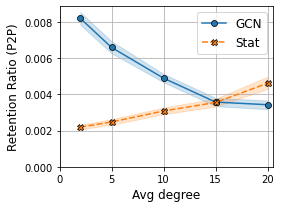

In [26]:
df = ws_df.loc[ws_df['name'].isin(['single','DGCN-LGS'])]
# sns.set(font_scale = 1.2)
ax = sns.lineplot(data=df, x='N_p', y='avg_p2p_ratio', 
                  hue='name', hue_order=['DGCN-LGS', 'single'], 
                  style='name', style_order=['DGCN-LGS', 'single'], 
                  markers=True, mec='k')
ax.set_xlim([0.0, 20.5])
ax.set_ylim([0.0, None])
ax.grid(True)
ax.legend(['GCN','Stat'], fontsize=12)
ax.set_xlabel('Avg degree', fontsize=12)
ax.set_ylabel('Retention Ratio (P2P)', fontsize=12)
# i += 1
fig = plt.gcf()
fig.set_size_inches(4, 3)
fname= os.path.join('./output/', 'sparse_wireless_p2p_ratio_{}_qr_nonorm.pdf'.format(graph))
plt.tight_layout()
fig.savefig(fname,
            dpi=300, #facecolor='w', edgecolor='w',
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')

In [252]:
ws_df_er = ws_df

In [14]:
df = pd.read_csv('./output/result_Theory3_deep_ld1_c32_l1_cheb1_diver1_mwis_dqn_ER_Graph_Uniform_GEN21_test2_lgs.csv')

In [16]:
df

,Unnamed: 0,data,p
0,0,ER_n100_p0.02_b0_uni.mat,0.992133
1,1,ER_n100_p0.02_b10_uni.mat,1.002788
2,2,ER_n100_p0.02_b11_uni.mat,0.991418
3,3,ER_n100_p0.02_b12_uni.mat,1.010330
4,4,ER_n100_p0.02_b13_uni.mat,0.997862
...,...,...,...
495,495,ER_n300_p0.067_b5_uni.mat,1.102981
496,496,ER_n300_p0.067_b6_uni.mat,1.029374
497,497,ER_n300_p0.067_b7_uni.mat,1.051736
498,498,ER_n300_p0.067_b8_uni.mat,1.047068


In [20]:
np.mean(df['p'].values)

1.041044429431524